In [ ]:
from Bio.Cluster import kcluster
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import shutil
import glob
import time
import os
import re

### Analysis input
input="CD45"
input_dataframe=pd.read_csv(f"output/{input}/opt_binders/metrics.csv")

os.makedirs(f"output/{input}/filtered_sequences/filtered_binders", exist_ok=True)
input_dataframe.describe()

,index,score,plddt,i_ptm,i_pae,i_con,rmsd,clusterid,ddg,rg,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
count,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,...,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000,3015.000000
mean,9463.809287,0.842515,0.924245,0.825413,5.232386,1.902996,0.544009,11.008955,-39.160050,11.286553,...,-34.997169,-2.922614,-2.606211,387.553157,2.784080,5.168491,-2.384411,8.477944,7.236484,1.241459
std,5647.405851,0.080558,0.012004,0.029025,0.544762,0.145683,0.250843,6.697234,7.082913,0.665599,...,7.320029,0.385746,0.387170,66.203536,1.755873,1.761342,1.527612,3.456060,3.034221,1.314032
min,4.000000,0.610719,0.900010,0.738954,3.371282,1.394882,0.083291,0.000000,-61.136000,10.304674,...,-58.244811,-3.974358,-3.850578,231.313828,1.000000,1.000000,-8.000000,1.000000,1.000000,-2.000000
25%,5252.500000,0.793976,0.915073,0.804919,4.864045,1.805789,0.361895,6.000000,-43.095000,10.848767,...,-39.741820,-3.198631,-2.832503,339.360992,2.000000,4.000000,-3.000000,6.000000,5.000000,0.000000
50%,9685.000000,0.843249,0.924118,0.822486,5.310778,1.914074,0.486029,12.000000,-39.061000,10.983361,...,-33.174381,-2.929492,-2.562460,371.981537,2.000000,5.000000,-2.000000,8.000000,7.000000,1.000000
75%,14454.000000,0.889649,0.932680,0.844014,5.685627,2.005971,0.683136,15.000000,-33.973500,11.780317,...,-29.857515,-2.667001,-2.358209,435.228729,3.000000,6.000000,-1.000000,10.000000,8.000000,2.000000
max,18538.000000,1.237020,0.962946,0.904927,5.999883,2.551491,1.467066,24.000000,-20.087000,14.748905,...,-0.755600,-1.626245,-0.045795,603.174500,11.000000,11.000000,3.000000,25.000000,21.000000,12.000000


## Filter dataframe
tipical metrics:
- plddt > 0.85-0.9
- i_pae < 5
- ddg_dsasa_100 < -2.5 - -3.5 (sort by)
additional metrics:
- charge < -2
- hyd_contacts > 4-6
- sap < 30-60

In [ ]:
filtered = input_dataframe[(input_dataframe["plddt"]>0.90)&
                           (input_dataframe["i_pae"]<7)&
                           (input_dataframe["ddg"]<-30)&
                           (input_dataframe["charge"]<-2)&
                           (input_dataframe["ddg_dsasa_100"]<-2)&
                           #(input_dataframe["ddgscore_dsasa_100"]<-2.5)&
                           (input_dataframe["shape_comp"]>0.5)&
                           (input_dataframe["vbuns_int"]<1)&
                           (input_dataframe["cms"]>400)&
                           (input_dataframe["hyd_contacts"]>4)]
                          # (input_dataframe["sap"]<100)]#&
                           #(input_dataframe["dG"]<30)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv", index=False)
filtered.reset_index(inplace=True)
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
0,2592,15505,0.917330,0.910142,0.844254,4.930314,1.819548,0.582076,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-44.737914,-3.912056,-3.303770,424.685394,1.0,7.0,-6.0,8.0,7.0,1.0
1,1350,15264,0.853516,0.925801,0.850322,4.615663,1.758891,0.922960,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-46.345404,-3.887109,-3.341984,404.118286,2.0,7.0,-5.0,6.0,5.0,1.0
2,101,15630,0.839662,0.945846,0.855126,4.369327,1.720920,0.464393,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-46.277579,-3.857942,-3.342310,406.827637,1.0,7.0,-6.0,9.0,8.0,1.0
3,1455,15253,0.913231,0.924716,0.835293,4.923484,1.826583,0.644933,output/CD45/opt_binders/binders/739X_pd_35_74_...,/home/tsatler/RFdif/ClusterProteinDesign/scrip...,...,-46.714250,-3.840897,-3.446894,414.777008,1.0,5.0,-4.0,6.0,6.0,0.0
4,649,10751,0.962018,0.934253,0.848462,4.677054,1.925789,0.437662,output/CD45/opt_binders/binders/1SM1_pd_30_41_...,output/CD45/opt_binders/binders/1SM1_pd_30_41_...,...,-41.664838,-3.838314,-3.024829,448.821533,4.0,5.0,-1.0,16.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,727,1333,1.043287,0.933073,0.877725,5.831052,1.805175,0.435025,output/CD45/opt_binders/binders/06MR_pd_35_66_...,output/CD45/opt_binders/binders/06MR_pd_35_66_...,...,-42.308330,-2.053100,-2.202080,541.705750,6.0,6.0,0.0,21.0,17.0,4.0
378,2739,11311,0.870498,0.907547,0.784172,5.138164,2.029383,0.705931,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,-31.755590,-2.041078,-1.955990,512.390320,8.0,9.0,-1.0,7.0,6.0,1.0
379,82,18440,0.972570,0.946540,0.891601,5.861993,1.684507,0.366155,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-40.630707,-2.040214,-2.507269,485.471558,5.0,7.0,-2.0,17.0,16.0,1.0
380,44,11461,0.818694,0.948397,0.859869,3.709496,1.623470,0.385450,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,-38.876098,-2.026808,-2.347656,486.006958,8.0,8.0,0.0,5.0,5.0,0.0


In [ ]:
filtered['rfd_id'] = filtered['input_pdb'].apply(lambda x: x.split(input+"_")[-1].split('.pdb')[0])
filtered['rfd_id']


rfd_id_counts = filtered['rfd_id'].value_counts()

# Get the number of unique 'rfd_id' values
unique_rfd_ids_count = filtered['rfd_id'].nunique()

# Display the counts of each 'rfd_id' and the number of unique 'rfd_id' values
print("Counts of each 'rfd_id':")
print(rfd_id_counts)
print("\nNumber of unique 'rfd_id' values:", unique_rfd_ids_count)

Counts of each 'rfd_id':
output/CD45/opt_binders/binders/08OM_pd_30_59_0/iterations/it_1/08OM_pd_30_59_0_1_8_1      8
output/CD45/opt_binders/binders/08OM_pd_30_59_0/iterations/it_1/08OM_pd_30_59_0_1_5_2      8
output/CD45/opt_binders/binders/08OM_pd_30_59_0/iterations/it_1/08OM_pd_30_59_0_1_5_1      7
output/CD45/opt_binders/binders/L7TM_pd_20_1_10/iterations/it_0/L7TM_pd_20_1_10_0_64       6
output/CD45/opt_binders/binders/06MR_pd_35_66_0/iterations/it_0/06MR_pd_35_66_0_0_54       6
                                                                                          ..
output/CD45/opt_binders/binders/4FSF_pd_30_50_29/iterations/it_0/4FSF_pd_30_50_29_0_78     1
output/CD45/opt_binders/binders/4D4P_pd_15_32_24/iterations/it_1/4D4P_pd_15_32_24_1_5_0    1
output/CD45/opt_binders/binders/1SM1_pd_30_19_7/iterations/it_2/1SM1_pd_30_19_7_2_4_1      1
output/CD45/opt_binders/binders/1SM1_pd_30_41_47/iterations/it_1/1SM1_pd_30_41_47_1_1_4    1
output/CD45/opt_binders/binders/L7TM_pd_20_1_

In [ ]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)

Total unique scaffolds: 10
Total scaffold instances: 382

Scaffold counts:
4FSF_pd    93
08OM_pd    79
4D4P_pd    53
739X_pd    43
2T0M_pd    41
06MR_pd    28
1SM1_pd    26
L7TM_pd    15
0XKF_pd     2
AUT3_pd     2
Name: scaffold_name, dtype: int64


In [ ]:
def repeat_rows_by_column_value(df, column_name, number):
    unique_values = df[column_name].unique()
    repeated_rows = []

    for value in unique_values:
        subset = df[df[column_name] == value]
        num_repeats = min(number, subset.shape[0])
        repeated_rows.extend([subset.iloc[i, :] for i in range(num_repeats)])

    repeated_df = pd.DataFrame(repeated_rows)
    return repeated_df
filtered=repeat_rows_by_column_value(filtered, "rfd_id", 100)
filtered.to_csv(f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/filtered_af2_rf2.csv")
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id
0,2592,15505,0.917330,0.910142,0.844254,4.930314,1.819548,0.582076,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.912056,-3.303770,424.685394,1.0,7.0,-6.0,8.0,7.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
7,2804,15517,0.952314,0.905805,0.848732,4.941667,1.781440,0.658335,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.812756,-3.443121,403.265015,1.0,6.0,-5.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
1,1350,15264,0.853516,0.925801,0.850322,4.615663,1.758891,0.922960,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.887109,-3.341984,404.118286,2.0,7.0,-5.0,6.0,5.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
11,532,15519,0.827922,0.936348,0.859841,4.286294,1.694456,0.689101,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.769878,-3.354151,420.322327,1.0,6.0,-5.0,7.0,4.0,3.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
33,2662,15521,0.827160,0.908981,0.833916,5.027245,1.859149,0.692596,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.615955,-3.334528,425.813416,2.0,8.0,-6.0,7.0,5.0,2.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,193,18432,0.961501,0.943167,0.888504,5.880367,1.733403,0.312266,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.137293,-2.310292,502.583344,5.0,7.0,-2.0,20.0,20.0,0.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...
375,118,18449,1.018016,0.945108,0.885934,5.957191,1.718753,0.403818,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.064267,-2.496471,493.884460,5.0,6.0,-1.0,21.0,19.0,2.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...
378,2739,11311,0.870498,0.907547,0.784172,5.138164,2.029383,0.705931,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,-2.041078,-1.955990,512.390320,8.0,9.0,-1.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...
379,82,18440,0.972570,0.946540,0.891601,5.861993,1.684507,0.366155,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.040214,-2.507269,485.471558,5.0,7.0,-2.0,17.0,16.0,1.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...


In [ ]:
#filtered=repeat_rows_by_column_value(filtered, "scaffold_name", 22)
filtered.to_csv(f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/filtered_af2_rf2.csv")
filtered

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id
0,2592,15505,0.917330,0.910142,0.844254,4.930314,1.819548,0.582076,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.912056,-3.303770,424.685394,1.0,7.0,-6.0,8.0,7.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
7,2804,15517,0.952314,0.905805,0.848732,4.941667,1.781440,0.658335,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.812756,-3.443121,403.265015,1.0,6.0,-5.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
1,1350,15264,0.853516,0.925801,0.850322,4.615663,1.758891,0.922960,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.887109,-3.341984,404.118286,2.0,7.0,-5.0,6.0,5.0,1.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
11,532,15519,0.827922,0.936348,0.859841,4.286294,1.694456,0.689101,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.769878,-3.354151,420.322327,1.0,6.0,-5.0,7.0,4.0,3.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
33,2662,15521,0.827160,0.908981,0.833916,5.027245,1.859149,0.692596,output/CD45/opt_binders/binders/739X_pd_35_74_...,output/CD45/opt_binders/binders/739X_pd_35_74_...,...,-3.615955,-3.334528,425.813416,2.0,8.0,-6.0,7.0,5.0,2.0,output/CD45/opt_binders/binders/739X_pd_35_74_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,193,18432,0.961501,0.943167,0.888504,5.880367,1.733403,0.312266,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.137293,-2.310292,502.583344,5.0,7.0,-2.0,20.0,20.0,0.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...
375,118,18449,1.018016,0.945108,0.885934,5.957191,1.718753,0.403818,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.064267,-2.496471,493.884460,5.0,6.0,-1.0,21.0,19.0,2.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...
378,2739,11311,0.870498,0.907547,0.784172,5.138164,2.029383,0.705931,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,-2.041078,-1.955990,512.390320,8.0,9.0,-1.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...
379,82,18440,0.972570,0.946540,0.891601,5.861993,1.684507,0.366155,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,-2.040214,-2.507269,485.471558,5.0,7.0,-2.0,17.0,16.0,1.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...


## Test with ColabFold and Rosettafold2

In [ ]:
def generate_fasta_sequence_from_pdb(pdb_file, output_folder=None):
    ca_pattern = re.compile("^ATOM\s{2,6}\d{1,5}\s{2}CA\s[\sA]([A-Z]{3})\s([\s\w])|^HETATM\s{0,4}\d{1,5}\s{2}CA\s[\sA](MSE)\s([\s\w])")
    aa3to1={
        'ALA':'A', 'VAL':'V', 'PHE':'F', 'PRO':'P', 'MET':'M',
        'ILE':'I', 'LEU':'L', 'ASP':'D', 'GLU':'E', 'LYS':'K',
        'ARG':'R', 'SER':'S', 'THR':'T', 'TYR':'Y', 'HIS':'H',
        'CYS':'C', 'ASN':'N', 'GLN':'Q', 'TRP':'W', 'GLY':'G',
        'MSE':'M',
    }
    filename = os.path.basename(pdb_file).split('.')[0]
    chain_dict = dict()
    chain_list = []

    with open(pdb_file, 'r') as fp:
        for line in fp:
            if line.startswith("ENDMDL"):
                break
            match_list = ca_pattern.findall(line)
            if match_list:
                resn = match_list[0][0] + match_list[0][2]
                chain = match_list[0][1] + match_list[0][3]
                if chain in chain_dict:
                    chain_dict[chain] += aa3to1[resn]
                else:
                    chain_dict[chain] = aa3to1[resn]
                    chain_list.append(chain)

    fasta_sequence = f">{filename}\n"
    for i, chain in enumerate(chain_list):
        fasta_sequence += chain_dict[chain]
        if i < len(chain_list) - 1:
            fasta_sequence += ':'

    if output_folder:
        output_file = os.path.join(output_folder, f"{filename}.fasta")
        with open(output_file, 'w') as fp:
            fp.write(fasta_sequence)

    return chain_dict

def process_a3m_file_rf2(binder_sequence, sample_a3m_path, processed_file_name, verbose=False):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        if verbose:
            print(lines[1])
        old_binder_sequence = lines[1].strip().split('/')[1]
        if verbose:
            print(old_binder_sequence)
        for i in range(0, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

            # Check if the line contains "-" and replace it accordingly
            if not lines[i].startswith('>') and lines[i].split('/')[1].startswith("-"):
                lines[i] = lines[i].split('/')[0] + "/" + "-" * len(binder_sequence) + "\n"

        # Save the processed lines to a new file
        new_file_path = f"{processed_file_name}"
        with open(new_file_path, 'w') as new_file:
            new_file.writelines(lines)

def process_a3m_file_af2(binder_sequence, sample_a3m_path, processed_file_name):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Extract the target sequence from the first line
        target_sequence_line = lines[0].strip()
        if target_sequence_line.startswith('#'):
            target_length = int(target_sequence_line[1:].split(',')[0].strip())
            #print(target_length)
        else:
            raise ValueError("The target sequence is not properly specified in the first line.")

        # Change line 0
        lines[0] = f"#{target_length},{len(binder_sequence)}\t1,1\n"
        # Change line 3
        target_sequence = lines[2].strip()[:target_length]
        old_binder_sequence = lines[2].strip()[target_length:]
        lines[2] = target_sequence + binder_sequence + "\n"

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        for i in range(3, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

        # Write the processed lines to the output file
        with open(processed_file_name, 'w') as processed_file:
            processed_file.writelines(lines)

## TEST

In [ ]:
# Create folders for samples
# make from whole sequence
msa_folder_rf2 = f"output/{input}/filtered_sequences/msa_inputs_rf2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_rf2 = f"{msa_folder_rf2}/sample"
os.makedirs(sample_msa_folder_rf2, exist_ok=True)

# AF2
msa_folder_af2 = f"output/{input}/filtered_sequences/msa_inputs_af2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_af2 = f"{msa_folder_af2}/sample"
os.makedirs(sample_msa_folder_af2, exist_ok=True)

# ?
filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders" #??
os.makedirs(filtered_binders_path, exist_ok=True)

# copy pdbs to filtered binders
for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    shutil.copyfile(model_path, new_model_path)

In [ ]:
filtered["seq"][0].split("/")[0]

'PSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHS'

In [ ]:
# prepare msa
#BTN3A1
#target_whole_seq="QFSVLGPSGPILAMVGEDADLPCHLFPTMSAETMELKWVSSSLRQVVNVYADGKEVEDRQSAPYRGRTSILRDGITAGKAALRIHNVTASDSGKYLCYFQDGDFYEKALVELKVAALGSDLHVDVKGYKDGGIHLECRSTGWYPQPQIQWSNNKGENIPTVEAPVVADGVGLYAVAASVIMRGSSGEGVSCTIRSSLLGLEKTASISIADPFF"
#ninj_m
target_whole_seq="FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDCLNLDKNLIKYDLQNLKPYTKYVLSLHAYIIAKVQRNGSAAMCHFTTKSAPPSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHSTS"
#target_whole_seq=filtered["seq"][0].split("/")[0]

sample_a3m_path_rf2 = f"{msa_folder_rf2}/sample/sample.a3m"
sample_a3m_path_af2 = f"{msa_folder_af2}/sample/sample.a3m"


random_binder_seq=filtered["seq"][0].split("/")[-1]
print(f"binder sequence: {random_binder_seq}")
print(f"target sequence: {target_whole_seq}")
# Create fasta
fasta_file_af2=f"{sample_msa_folder_af2}/fasta.fasta"
with open(f"{fasta_file_af2}", "w") as f:
    # Write the sequence to the file in FASTA format
    f.write(f">sample\n{target_whole_seq}:{random_binder_seq}\n")

binder sequence: MKKTEIINLSSSDTVLELPEGEIEITVSLNVGQTATVNIERVDGKLKLTVKLSSGAKATIVHTTE
target sequence: FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDCLNLDKNLIKYDLQNLKPYTKYVLSLHAYIIAKVQRNGSAAMCHFTTKSAPPSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHSTS


In [ ]:
### Generate MSA for AF2 and RF2


### AF2
input_pdb=filtered["model_path"][0]
slurm_args="" #"--output=/dev/null"
cmd = f"sbatch {slurm_args} helper_scripts/get_msa_colabfold.sh {input_pdb} {sample_msa_folder_af2}"

# Run the system command to execute the get_msa.py script
#a3m_path_af2 = f"{sample_msa_folder_af2}/{input_pdb.split('/')[-1].split('.')[0]}.a3m"
if not os.path.exists(sample_a3m_path_af2):
    os.system(cmd)

### RF2
cmd_rf2 = f"sbatch {slurm_args} helper_scripts/get_msa_rf.sh {fasta_file_af2} {sample_msa_folder_rf2}"

# Run the system command to execute the get_msa.py script
#sample_a3m_path = f"{sample_msa_folder_rf2}/sample.a3m"
if not os.path.exists(sample_a3m_path_rf2):
    os.system(cmd_rf2)


### WAITING
# Wait until MSA is calculated...
while not os.path.exists(sample_a3m_path_af2):
    time.sleep(1)

print("MSA calculation for AF2 is complete.")

while not os.path.exists(sample_a3m_path_rf2):
    time.sleep(1)
print("MSA calculation for RF2 is complete.")


Submitted batch job 387491
Submitted batch job 387492
MSA calculation for AF2 is complete.
MSA calculation for RF2 is complete.


In [ ]:
### Generate other MSA files for RF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_rf2"]=None

filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders"
os.makedirs(filtered_binders_path, exist_ok=True)

binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)
    binder_seq=row["seq"].split("/")[-1]

    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    a3m_file_name=f"{msa_folder_rf2}/{model_name.split('.')[0]}.a3m"
    sample_a3m_path = sample_a3m_path_rf2
    process_a3m_file_rf2(binder_seq, sample_a3m_path, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_rf2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_rf2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with RF2!")

### Generate other MSA files for AF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_af2"]=None


binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)

    # Generate msa
    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    binder_seq=row["seq"].split("/")[-1]
    a3m_file_name=f"{msa_folder_af2}/{model_name.split('.')[0]}.a3m"
    #sample_a3m_path_af2="/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/5fmv_domain3-4/filtered_sequences/msa_inputs_af2/sample/sample.a3m"
    process_a3m_file_af2(binder_seq, sample_a3m_path_af2, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_af2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_af2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with AF2!")

There is 382 a3m files ready to be predicted with RF2!


There is 382 a3m files ready to be predicted with AF2!


### Generate RF2 MSA files

### Run prediction

In [ ]:
# Set the prediction options as a dictionary with booleans
prediction_options = {
    "colabfold": True,       # Set to True if you want to run ColabFold
    "rosettafold2": True,    # Set to True if you want to run RosettaFold2 (not currently used)
    "esmfold": False,        # Set to True if you want to run ESMfold (not currently used)
}

array_limit=10
binder_analysis="binder-second" # if you want to perform binder analysis
msa_folder=f"output/{input}/filtered_sequences"

array_number=len(msa_a3m_inputs)
#array_number=300
tools = " ".join([tool for tool, should_run in prediction_options.items() if should_run])
print(tools)
bash_arguments=f"--array=0-{array_number}%{array_limit}"
#bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
script_arguments=f"{msa_folder} {filtered_binders_path} {binder_analysis} {tools} "

command = f"sbatch {bash_arguments} helper_scripts/predict_binders.sh {script_arguments}"
print(command)

colabfold rosettafold2
sbatch --array=0-382%10 helper_scripts/predict_binders.sh output/CD45/filtered_sequences output/CD45/filtered_sequences/filtered_binders binder-second colabfold rosettafold2 


In [ ]:
subprocess.run(command, shell=True)

Submitted batch job 387493


CompletedProcess(args='sbatch --array=0-382%10 helper_scripts/predict_binders.sh output/CD45/filtered_sequences output/CD45/filtered_sequences/filtered_binders binder-second colabfold rosettafold2 ', returncode=0)

### Append and filter with scores

In [ ]:
#af2_dataframe_columns = ['plddt', 'pae', 'binder_plddt', 'target_plddt', 'pae_binder', 'pae_target', 'pae_int_tot', 'rmsd', 'name', 'model_id']
#rf2_dataframe_columns = ['mean_plddt', 'pae_chain0_0', 'rmsd', 'name', 'model_id', 'plddt_target', 'plddt_binder', 'plddt', 'pae']

# Open filtered dataframe
filtered=pd.read_csv(f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/filtered_af2_rf2.csv")
#filtered = pd.read_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv")
filtered["model_id"]=filtered["model_path"].str.split("/").str[-1].str.split(".").str[0]

# Open scores to append
af2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_af2.csv")
#rf2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_rf2.csv")
# Fix old model_ids
af2_scores["model_id"] = af2_scores["model_id"].str.replace(r"-AF2$", "", regex=True)
#rf2_scores["model_id"] = rf2_scores["model_id"].str.replace(r"-RF2$", "", regex=True)

# Columns to append
af2_column_append = ['binder_plddt', 'pae_int_tot', 'rmsd']
#rf2_column_append = ['plddt_binder', 'pae', 'rmsd']

# Prepare columns to add
#rf2_scores = rf2_scores[rf2_column_append + ['model_id']].rename(columns=lambda x: f'rf_{x}' if x != 'model_id' else x)
af2_scores = af2_scores[af2_column_append + ['model_id']].rename(columns=lambda x: f'af_{x}' if x != 'model_id' else x)

# Merge to filtered
filtered = filtered.merge(af2_scores, on='model_id', how='left')
#filtered = filtered.merge(rf2_scores, on='model_id', how='left')
filtered.describe()

,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,clusterid,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,382.000000,382.00000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,379.000000,379.000000,379.000000
mean,190.500000,1322.86911,10047.874346,0.870169,0.927020,0.841375,5.082492,1.830398,0.517521,8.717277,...,474.079884,3.863874,6.172775,-2.308901,11.685864,9.662304,2.023560,92.088439,7.932749,1.720555
std,110.418145,935.89283,6163.329875,0.115706,0.013313,0.035593,0.615524,0.133481,0.244126,5.588107,...,47.582026,2.159592,2.252206,2.272482,4.705585,4.494218,1.367785,5.756902,2.441038,1.302713
min,0.000000,2.00000,8.000000,0.610719,0.900229,0.747911,3.579909,1.494151,0.089465,1.000000,...,400.019592,1.000000,1.000000,-8.000000,3.000000,1.000000,0.000000,70.142703,4.289395,0.375717
25%,95.250000,401.25000,1371.250000,0.794177,0.916721,0.815328,4.562822,1.727119,0.354038,5.000000,...,439.677269,2.000000,5.000000,-4.000000,8.000000,6.000000,1.000000,90.660216,6.199009,0.902044
50%,190.500000,1310.00000,12468.000000,0.870575,0.926187,0.839107,4.976392,1.821606,0.475967,7.000000,...,468.551636,4.000000,6.000000,-1.500000,10.000000,8.000000,2.000000,94.378703,7.575671,1.507097
75%,285.750000,2152.50000,14467.000000,0.939350,0.938502,0.874484,5.767082,1.926709,0.644061,10.000000,...,496.992027,5.000000,8.000000,0.000000,15.000000,13.000000,3.000000,96.153730,8.819243,2.147837
max,381.000000,3005.00000,18529.000000,1.237020,0.956313,0.904927,5.997898,2.196687,1.462478,23.000000,...,603.174500,9.000000,11.000000,0.000000,25.000000,20.000000,7.000000,97.436649,14.214225,7.778489


In [ ]:
fil=filtered
fil.describe()

,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,clusterid,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,382.000000,382.00000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,379.000000,379.000000,379.000000
mean,190.500000,1322.86911,10047.874346,0.870169,0.927020,0.841375,5.082492,1.830398,0.517521,8.717277,...,474.079884,3.863874,6.172775,-2.308901,11.685864,9.662304,2.023560,92.088439,7.932749,1.720555
std,110.418145,935.89283,6163.329875,0.115706,0.013313,0.035593,0.615524,0.133481,0.244126,5.588107,...,47.582026,2.159592,2.252206,2.272482,4.705585,4.494218,1.367785,5.756902,2.441038,1.302713
min,0.000000,2.00000,8.000000,0.610719,0.900229,0.747911,3.579909,1.494151,0.089465,1.000000,...,400.019592,1.000000,1.000000,-8.000000,3.000000,1.000000,0.000000,70.142703,4.289395,0.375717
25%,95.250000,401.25000,1371.250000,0.794177,0.916721,0.815328,4.562822,1.727119,0.354038,5.000000,...,439.677269,2.000000,5.000000,-4.000000,8.000000,6.000000,1.000000,90.660216,6.199009,0.902044
50%,190.500000,1310.00000,12468.000000,0.870575,0.926187,0.839107,4.976392,1.821606,0.475967,7.000000,...,468.551636,4.000000,6.000000,-1.500000,10.000000,8.000000,2.000000,94.378703,7.575671,1.507097
75%,285.750000,2152.50000,14467.000000,0.939350,0.938502,0.874484,5.767082,1.926709,0.644061,10.000000,...,496.992027,5.000000,8.000000,0.000000,15.000000,13.000000,3.000000,96.153730,8.819243,2.147837
max,381.000000,3005.00000,18529.000000,1.237020,0.956313,0.904927,5.997898,2.196687,1.462478,23.000000,...,603.174500,9.000000,11.000000,0.000000,25.000000,20.000000,7.000000,97.436649,14.214225,7.778489


### Filter sequences

In [ ]:
filtered = fil[(fil["af_binder_plddt"]>70)&
                    #(filtered["af_pae_int_tot"]<7)&
                    (fil["af_rmsd"]<1.2)]#&

                    #(filtered["rf_plddt_binder"]>78)&
                    #(filtered["rf_pae"]<15)&
                    #(filtered["rf_rmsd"]<3)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/1_filtered_binders.csv", index=False)
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)
filtered

Total unique scaffolds: 6
Total scaffold instances: 172

Scaffold counts:
4D4P_pd    51
2T0M_pd    40
4FSF_pd    36
06MR_pd    28
L7TM_pd    15
0XKF_pd     2
Name: scaffold_name, dtype: int64


,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,...,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id,model_id,af_binder_plddt,af_pae_int_tot,af_rmsd
42,26,290,13701,1.082358,0.941130,0.897869,5.844235,1.654734,0.598778,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,...,6.0,-2.0,16.0,14.0,2.0,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,4D4P_pd_15_89_12_1_9_0,97.130054,4.572372,0.707203
43,28,42,12667,0.873868,0.948436,0.883982,5.996095,1.704869,0.310514,output/CD45/opt_binders/binders/4D4P_pd_15_56_...,...,6.0,0.0,22.0,18.0,4.0,output/CD45/opt_binders/binders/4D4P_pd_15_56_...,4D4P_pd_15_56_38_1_9_2,96.992649,6.021802,0.923951
50,35,399,14264,0.938611,0.938546,0.859899,4.332323,1.696221,0.429050,output/CD45/opt_binders/binders/4FSF_pd_30_59_...,...,6.0,-5.0,11.0,10.0,1.0,/home/tsatler/RFdif/ClusterProteinDesign/scrip...,4FSF_pd_30_59_2_0_5,92.428000,8.412822,1.005254
53,38,495,14051,0.976984,0.936931,0.893401,5.932653,1.708098,0.419754,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,...,7.0,-2.0,16.0,14.0,2.0,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,4D4P_pd_15_89_12_2_1_2,96.842919,5.992654,0.903618
60,42,2463,14141,0.962438,0.911990,0.778530,5.582322,2.058419,1.065286,output/CD45/opt_binders/binders/4FSF_pd_30_50_...,...,9.0,-6.0,12.0,7.0,5.0,output/CD45/opt_binders/binders/4FSF_pd_30_50_...,4FSF_pd_30_50_29_1_7_1,87.096649,8.693866,0.375717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,377,727,1333,1.043287,0.933073,0.877725,5.831052,1.805175,0.435025,output/CD45/opt_binders/binders/06MR_pd_35_66_...,...,6.0,0.0,21.0,17.0,4.0,output/CD45/opt_binders/binders/06MR_pd_35_66_...,06MR_pd_35_66_0_2_4_3,96.476595,4.922519,0.615582
379,378,2739,11311,0.870498,0.907547,0.784172,5.138164,2.029383,0.705931,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,9.0,-1.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,2T0M_pd_30_43_5_1_8_1,93.576541,8.015070,0.836428
380,379,82,18440,0.972570,0.946540,0.891601,5.861993,1.684507,0.366155,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,7.0,-2.0,17.0,16.0,1.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,L7TM_pd_20_1_10_2_7_4,97.100324,4.595039,0.848336
360,380,44,11461,0.818694,0.948397,0.859869,3.709496,1.623470,0.385450,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,8.0,0.0,5.0,5.0,0.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,2T0M_pd_30_43_5_2_2_2,96.372324,6.238975,1.087484


In [ ]:
### Remove certain scaffolds

bad_scaffolds = ["0XKF_pd", "4FSF_pd", "06MR_pd"]
filtered = filtered[~filtered["scaffold_name"].isin(bad_scaffolds)]
scaffold_counts = filtered["scaffold_name"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)
filtered

Total unique scaffolds: 3
Total scaffold instances: 106

Scaffold counts:
4D4P_pd    51
2T0M_pd    40
L7TM_pd    15
Name: scaffold_name, dtype: int64


,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,...,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,rfd_id,model_id,af_binder_plddt,af_pae_int_tot,af_rmsd
42,26,290,13701,1.082358,0.941130,0.897869,5.844235,1.654734,0.598778,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,...,6.0,-2.0,16.0,14.0,2.0,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,4D4P_pd_15_89_12_1_9_0,97.130054,4.572372,0.707203
43,28,42,12667,0.873868,0.948436,0.883982,5.996095,1.704869,0.310514,output/CD45/opt_binders/binders/4D4P_pd_15_56_...,...,6.0,0.0,22.0,18.0,4.0,output/CD45/opt_binders/binders/4D4P_pd_15_56_...,4D4P_pd_15_56_38_1_9_2,96.992649,6.021802,0.923951
53,38,495,14051,0.976984,0.936931,0.893401,5.932653,1.708098,0.419754,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,...,7.0,-2.0,16.0,14.0,2.0,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,4D4P_pd_15_89_12_2_1_2,96.842919,5.992654,0.903618
63,46,40,12278,0.967181,0.948534,0.896018,5.887553,1.639029,0.486029,output/CD45/opt_binders/binders/4D4P_pd_15_15_...,...,5.0,-2.0,16.0,15.0,1.0,output/CD45/opt_binders/binders/4D4P_pd_15_15_...,4D4P_pd_15_15_12_3_6_2,97.258486,4.583587,0.844097
68,51,128,14054,1.117570,0.944875,0.894263,5.858134,1.692815,0.429472,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,...,5.0,-2.0,14.0,13.0,1.0,output/CD45/opt_binders/binders/4D4P_pd_15_89_...,4D4P_pd_15_89_12_1_3_4,96.275459,6.220591,0.929153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,376,2864,11309,0.876238,0.904475,0.782209,5.450329,2.041469,0.697044,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,8.0,0.0,7.0,3.0,4.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,2T0M_pd_30_43_5_1_5_3,95.715027,6.783087,0.881740
379,378,2739,11311,0.870498,0.907547,0.784172,5.138164,2.029383,0.705931,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,9.0,-1.0,7.0,6.0,1.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,2T0M_pd_30_43_5_1_8_1,93.576541,8.015070,0.836428
380,379,82,18440,0.972570,0.946540,0.891601,5.861993,1.684507,0.366155,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,...,7.0,-2.0,17.0,16.0,1.0,output/CD45/opt_binders/binders/L7TM_pd_20_1_1...,L7TM_pd_20_1_10_2_7_4,97.100324,4.595039,0.848336
360,380,44,11461,0.818694,0.948397,0.859869,3.709496,1.623470,0.385450,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,...,8.0,0.0,5.0,5.0,0.0,output/CD45/opt_binders/binders/2T0M_pd_30_43_...,2T0M_pd_30_43_5_2_2_2,96.372324,6.238975,1.087484


# Cluster sequences

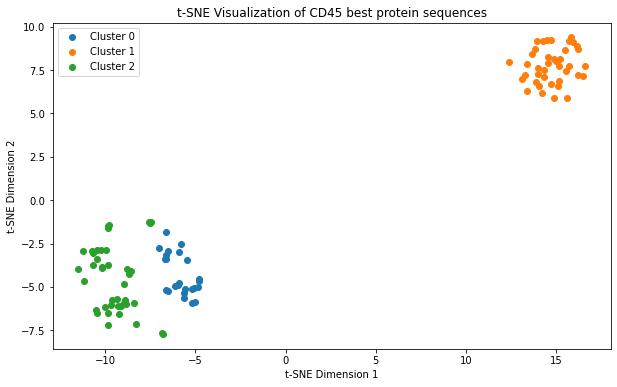

Cluster 0: 24 sequences
Scaffold Names: 4D4P_pd
Cluster 1: 40 sequences
Scaffold Names: 2T0M_pd
Cluster 2: 42 sequences
Scaffold Names: 4D4P_pd, L7TM_pd


,Unnamed: 0,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,ddg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
clusterid,,,,,,,,,,,,,,,,,,,,,
0,161.125000,208.166667,13485.833333,1.000199,0.943533,0.896568,5.895533,1.648816,0.451233,-52.916792,...,543.269281,4.416667,5.958333,-1.541667,18.333333,16.416667,1.916667,95.934930,5.665412,0.904877
1,312.275000,1907.825000,11478.525000,0.866636,0.918733,0.810100,4.841340,1.917221,0.649015,-41.736125,...,468.708301,8.000000,8.375000,-0.375000,6.425000,5.000000,1.425000,94.187128,7.292208,0.754048
2,261.357143,259.380952,14908.666667,0.982508,0.942725,0.889893,5.908542,1.715100,0.435088,-45.274690,...,511.335148,5.071429,6.000000,-0.928571,18.690476,16.976190,1.714286,96.784866,5.395762,0.931966


In [ ]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=3

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

cluster_counts = Counter(filtered['clusterid'])

# Group the DataFrame by 'clusterid' and get unique scaffold names for each group
unique_scaffold_names = filtered.groupby('clusterid')['scaffold_name'].unique()

# Iterate over the groups and print both cluster counts and unique scaffold names
for cluster_id, scaffold_names in unique_scaffold_names.items():
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} sequences")
    print(f'Scaffold Names: {", ".join(scaffold_names)}')

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

# Output final dataframe and binders
Code below will create folders with best [12, 24, 48 ..] binders and metrics.
Make sure to change cluster ratios based on the results above!

In [ ]:
# Select number of final sequences and cluster ratios
total_numbers=[12, 24, 48]
#total_numbers=[10, 20, 40]
#cluster_ratios = [0.4, 0.3, 0.3]
#cluster_ratios = [0.3,0.1,0.2,0.1,0.2,0.2]
cluster_ratios = [0.33, 0.33, 0.33]

# Function to calculate the number of sequences for each cluster based on the given ratios
def calculate_sequences_ratios(total_sequences, cluster_ratios):
    cluster_sequences = {}
    total_ratio = sum(cluster_ratios)
    remaining_sequences = total_sequences

    for i, ratio in enumerate(cluster_ratios):
        if i == len(cluster_ratios) - 1:
            cluster_sequences[i] = remaining_sequences
        else:
            sequences_for_cluster = int(total_sequences * ratio / total_ratio)
            cluster_sequences[i] = sequences_for_cluster
            remaining_sequences -= sequences_for_cluster

    return cluster_sequences

In [ ]:
cluster_sequences = calculate_sequences_ratios(12, cluster_ratios)
cluster_sequences

{0: 4, 1: 4, 2: 4}

In [ ]:

for total_sequences in total_numbers:
    # Calculate the number of sequences for each cluster
    cluster_sequences = calculate_sequences_ratios(total_sequences, cluster_ratios)
    print(f"Total Sequences: {total_sequences}")
    print(cluster_sequences)

    # Create a new dataframe with the final number of sequences for each cluster
    final_sequences = []
    for cluster_id, num_sequences in cluster_sequences.items():
        cluster_data = filtered[filtered['clusterid'] == cluster_id].iloc[:num_sequences]
        final_sequences.append(cluster_data)

    final_dataframe = pd.concat(final_sequences)

    # Save the dataframe to a CSV file
    binder_pdbs_path=f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]

        #filtered_binders_path=f"output/{input}/filtered_sequences/colab_rf_eval_2domain_and_binder/filtered_binders"s
        # Copy pdb in filtered folder
        #model_path=row["model_path"]
        #model_name=model_path.split("/")[-1]
        #pdb_path=f"{filtered_binders_path}/{model_name}"

        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
            #print(f"Copied {pdb_filename} to {destination_path}")
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Total Sequences: 12
{0: 4, 1: 4, 2: 4}
DataFrame for 12 sequences saved to output/CD45/filtered_sequences/final_results/binders_12/final_binders_12.csv
Total Sequences: 24
{0: 8, 1: 8, 2: 8}
DataFrame for 24 sequences saved to output/CD45/filtered_sequences/final_results/binders_24/final_binders_24.csv
Total Sequences: 48
{0: 16, 1: 16, 2: 16}
DataFrame for 48 sequences saved to output/CD45/filtered_sequences/final_results/binders_48/final_binders_48.csv


In [ ]:
total_numbers = [12, 24, 48]

# Initialize an empty list to collect scaffold_filtered DataFrames


for total_sequences in total_numbers:
    scaffolds_len = len(filtered["scaffold_name"].unique())
    all_scaffold_filtered = []
    for scaffold in filtered["scaffold_name"].unique():
        scaffold_filtered = filtered[filtered["scaffold_name"] == scaffold]
        sequences_to_take = int(total_sequences / scaffolds_len + 0.5)
        scaffold_filtered = scaffold_filtered.head(sequences_to_take)
        print(f"Scaffold: {scaffold}, Sequences to take: {sequences_to_take}")
        
        # Append scaffold_filtered DataFrame to the list
        all_scaffold_filtered.append(scaffold_filtered)

    # Concatenate all scaffold_filtered DataFrames into final_dataframe
    final_dataframe = pd.concat(all_scaffold_filtered)

    binder_pdbs_path = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]

        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Scaffold: 4D4P_pd, Sequences to take: 4
Scaffold: 2T0M_pd, Sequences to take: 4
Scaffold: L7TM_pd, Sequences to take: 4
DataFrame for 12 sequences saved to output/CD45/filtered_sequences/final_results/binders_12/final_binders_12.csv
Scaffold: 4D4P_pd, Sequences to take: 8
Scaffold: 2T0M_pd, Sequences to take: 8
Scaffold: L7TM_pd, Sequences to take: 8
DataFrame for 24 sequences saved to output/CD45/filtered_sequences/final_results/binders_24/final_binders_24.csv
Scaffold: 4D4P_pd, Sequences to take: 16
Scaffold: 2T0M_pd, Sequences to take: 16
Scaffold: L7TM_pd, Sequences to take: 16
DataFrame for 48 sequences saved to output/CD45/filtered_sequences/final_results/binders_48/final_binders_48.csv


In [ ]:
filtered["scaffold_name"].unique()

array(['4D4P_pd', '2T0M_pd', 'L7TM_pd'], dtype=object)

Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 3
Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 7
Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 15
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 3
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 7
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 15
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 3
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 7
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 15
DataFrame for 12 sequences saved to output/CD45/filtered_sequences/final_results/binders_12/final_binders_12.csv
DataFrame for 24 sequences saved to output/CD45/filtered_sequences/final_results/binders_24/final_binders_24.csv
DataFrame for 48 sequences saved to output/CD45/filtered_sequences/final_results/binders_48/final_binders_48.csv


### other scaffolds

In [ ]:
new_other_seq = pd.read_csv("/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/other/stats.csv", delimiter=";", header=1)
new_other_seq

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,dG,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100
0,6656,15650,0.938849,0.948379,0.897571,6.402125,1.748177,0.610525,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,-11.417756,1419.502817,-0.804349,7.0,2.0,8.0,0.730116,-44.573582,-3.565192,-3.140084
1,6012,18635,0.620146,0.949821,0.892687,6.556802,1.706465,0.194243,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,14.745972,1380.435903,1.068211,11.0,2.0,7.0,0.688978,-45.839116,-3.703323,-3.320626
2,7203,14234,0.566605,0.947555,0.893287,6.370740,1.712524,0.228130,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,72.313913,1393.980216,5.187585,11.0,1.0,8.0,0.648218,-42.952482,-3.672505,-3.081284
3,2777,20149,0.558008,0.957252,0.898240,6.274981,1.655755,0.284202,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,41.781513,1378.001936,3.032036,12.0,1.0,7.0,0.675505,-44.215079,-3.642811,-3.208637
4,6089,7311,0.611378,0.949616,0.893010,6.450777,1.710389,0.271164,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,56.065544,1400.766793,4.002489,11.0,1.0,7.0,0.661088,-43.167257,-3.642077,-3.081688
5,5947,20201,0.556906,0.949994,0.894093,6.413862,1.701892,0.320820,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,114.422784,1420.467620,8.055290,8.0,0.0,7.0,0.676967,-41.782507,-3.641195,-2.941461
6,7006,14294,0.542688,0.947865,0.891099,6.491175,1.723147,0.224487,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,60.906963,1398.527412,4.355078,11.0,1.0,7.0,0.646354,-43.635885,-3.630962,-3.120131
7,5127,20169,0.674446,0.952414,0.897353,6.320350,1.669022,0.279404,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,54.378165,1398.254132,3.889004,11.0,2.0,8.0,0.667757,-47.551372,-3.624806,-3.400767
8,7349,18671,0.557568,0.947368,0.891600,6.596428,1.723198,0.249942,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,18.388672,1384.524239,1.328158,11.0,1.0,7.0,0.673593,-43.520569,-3.624639,-3.143359
9,5381,18567,0.614900,0.951708,0.893030,6.468930,1.700862,0.194906,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,28.796804,1383.146213,2.081978,11.0,1.0,7.0,0.675219,-44.512690,-3.622249,-3.218220


In [ ]:
new_other_seq["seq_split"] = new_other_seq["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=2

seqs=new_other_seq["seq_split"].to_list()

In [ ]:
new_other_seq["seq_split"]

0     DEEWRKRTLEAVRAKDKAGIFESLYETLEEYDKTKDEELKELARLL...
1     MYLVIAKDADPEKAILVAKAAGLEDIEVEDGNVYIYAETKSKAEQV...
2     MYLVIAENADEKKAILVAEAAGLKDIKVENGNVYVYAETKEKAEQV...
3     MYLVVAYNADAEKAILVAEAAGLTDIEVKDGNVYVRAETKEKAEQV...
4     MYLVIAKNADIEKAVLVAEAAGLTDIRVENGDVLIYAPTKEKAEQV...
5     MYLVTAYNADEEKAILVAEAAGLTDIEVKDGNVYIYADTKEKAEQV...
6     MYLVIAENADAEKAILVAEAAGLKDIEVKDGNVYIYAETKEKAEQV...
7     MYLVIAENADVEKAELVARAAGLTDIEVKDGNVYVYAKTKQKAEQV...
8     MYKVIAENADPEKAILVAEAAGLTDIEVEDGNVYIYAETKEKAEQV...
9     MYLVTAVNADAEKAILVAEAAGLTDIEVKDGNVYIYADTKEKAEQV...
10    MYLVKAKNADPEKAILVAEAAGLKDIEVKDGDVYIYAETKEKAEQV...
11    MYLVTAHNADKEKAILVAEAAGLKDIRVENGNVYIYAETKEKAEQV...
12    MYKVIAENADEEKAILVAEAAGLKDIEVKDGDVYIYAETKEKAEQV...
13    MYLVIAKNADIEKAVLVAEAAGLTDIRVENGNVYIYAETKEKAEQV...
14    MYLVIAENADPEKAILVAEAAGLTDIEVRDGNVYIYADTKEKAEQV...
15    MYLVTAKNADEKKAILVAEAAGLTDIEVKDGNVYVRAETKEKAEQV...
16    MYLVTAYNADEEKSILVAEAAGLKDIEVENGNVYIYAPTEEKAKQV...
17    MYKVIAENADEEKAILVAEAAGLKDIEVKDGNVYIYAETKEK

In [ ]:
destination_path = "/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/batch1"
os.makedirs(destination_path, exist_ok=True)

# for i,row in new_other_seq.head(2).iterrows():
#     model_path=row["model_path"]
#     model_name=model_path.split("/")[-1]
#     new_model_path=f"{destination_path}/{model_name}"
#     shutil.copyfile(model_path, new_model_path)

new_other_seq.head(2).to_csv(f"{destination_path}/other.csv", index=False)